# 汽车边缘识别
    1.随机取汽车图片上的一小块patch,凡是取到了一个像素的汽车,就作为正例数据集,car
    2.随机取汽车图片上的一小块patch,凡是取到了非汽车区域,就作为负例数据集,noncar
    3.标注数据不仅仅是0和1,还需要训练汽车的边缘特征

In [1]:
import os
import os.path
from os import walk
from os.path import join
import numpy as np

base_path = '/workspace/lianxi/Kaggle/car_recognition/'

def get_picture(path):
    path0 = join(base_path + path)
    picture = []
    for _,_,filenames in walk(path0):
        for filename in filenames:
            file_prefix = os.path.splitext(filename)[0]
            if os.path.exists(join(path0, file_prefix + ".jpg")):
                picture.append(filename)
            elif os.path.exists(join(path0, file_prefix + ".gif")):
                picture.append(filename)
            else:
                print("路径不对或者没有这种格式的文件")
    return picture

In [2]:
car_pictures = get_picture("train")

mask_pictures = get_picture("train_masks")

len(car_pictures), len(mask_pictures)

(5088, 5088)

In [3]:
train_set = car_pictures[0:3801]
valid_set = car_pictures[3801:5068]
test_set = car_pictures[5068:5088]
len(train_set),len(valid_set),len(test_set)

(3801, 1267, 20)

In [4]:
train_random_choice = np.random.choice(train_set)
train_random_choice_path = join(base_path, "train/" + train_random_choice)
train_random_mask_path = join(base_path, "train_masks/" + (train_random_choice.split("."))[0] + "_mask.gif")

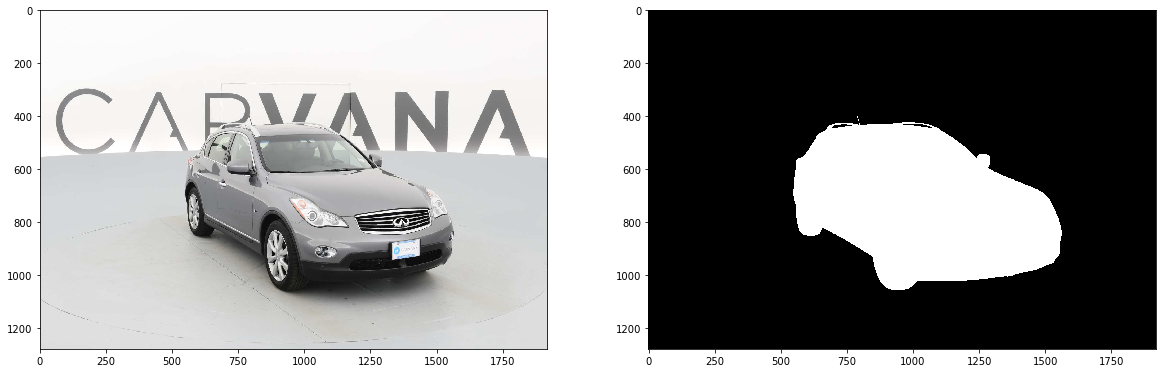

In [5]:
# car_p = ((car_pictures[0]).split("."))[0]

import matplotlib.pyplot as plt
import matplotlib.image as image
%matplotlib inline

# f=plt.imread('../train/61060ada97c9_01.jpg')
car_pic = image.imread(train_random_choice_path)
mask_pic = image.imread(train_random_mask_path)

f, axes = plt.subplots(1,2,figsize=(20,10))
ax = axes.ravel()
ax[0].imshow(car_pic)
ax[1].imshow(mask_pic)

In [6]:
car_pic.shape

(1280, 1918, 3)

In [7]:
mask_pic.shape[0]

1280

In [8]:
import openslide
from keras.utils.np_utils import to_categorical

def data_generator(data_set, batch_size=32, widths=150, heights=150):

    images = []
    masks = []
    for i in range(batch_size):
        train_random_choice = np.random.choice(train_set)
        train_random_choice_path = join(base_path, "train/" + train_random_choice)
        train_random_mask_path = join(base_path, "train_masks/" + (train_random_choice.split("."))[0] + "_mask.gif")

        car_pic = image.imread(train_random_choice_path)
        mask_pic = image.imread(train_random_mask_path)

        random_num = np.random.random(1)
#         print("产生的随机数是:%s"%random_num)
        if random_num > 0.5:    # 必须取到一张包含汽车至少一个像素的图片
            random_x = np.random.randint(0, car_pic.shape[1] - widths)
            random_y = np.random.randint(0, car_pic.shape[0] - heights)
            slide = openslide.open_slide(train_random_mask_path)
            slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
            slide_arr = np.array(slide1.convert("L"))
            slide_y, slide_x = np.nonzero(slide_arr)
            while len(slide_x) == 0:
                random_x = np.random.randint(0, car_pic.shape[1] - widths)
                random_y = np.random.randint(0, car_pic.shape[0] - heights)
                slide = openslide.open_slide(train_random_mask_path)
                slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                slide_arr = np.array(slide1.convert("L"))
                slide_y, slide_x = np.nonzero(slide_arr)
            masks.append((slide_arr>0).astype(int))
            img = (openslide.open_slide(train_random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
            images.append(np.array(img.convert("RGB")))
        else:
            random_x = np.random.randint(0, car_pic.shape[1] - widths)
            random_y = np.random.randint(0, car_pic.shape[0] - heights)
            slide = openslide.open_slide(train_random_mask_path)
            slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
            slide_arr = np.array(slide1.convert("L"))
            slide_y, slide_x = np.nonzero(slide_arr)
            while len(slide_x) != 0:
                random_x = np.random.randint(0, car_pic.shape[1] - widths)
                random_y = np.random.randint(0, car_pic.shape[0] - heights)
                slide = openslide.open_slide(train_random_mask_path)
                slide1 = slide.read_region((random_x,random_y), 0, (widths, heights))
                slide_arr = np.array(slide1.convert("L"))
                slide_y, slide_x = np.nonzero(slide_arr)
            masks.append(np.zeros((widths,heights)))
            img = (openslide.open_slide(train_random_choice_path)).read_region((random_x,random_y),0,(widths,heights))
            images.append(np.array(img.convert("RGB")))

    X_train = np.array(images)
    y_train = np.array(masks)
    print(y_train.shape[0],y_train.shape[1])
    y_train = to_categorical(y_train, num_classes=2).reshape(y_train.shape[0], widths, heights, 2)
    yield X_train,y_train

Using TensorFlow backend.


产生的随机数是:[ 0.55742682]
产生的随机数是:[ 0.59350649]
产生的随机数是:[ 0.82156517]
产生的随机数是:[ 0.06487174]
产生的随机数是:[ 0.04496514]
产生的随机数是:[ 0.24459884]
产生的随机数是:[ 0.17429998]
产生的随机数是:[ 0.10656834]
产生的随机数是:[ 0.54874532]
产生的随机数是:[ 0.73229898]
产生的随机数是:[ 0.33566105]
产生的随机数是:[ 0.60944389]
产生的随机数是:[ 0.3088747]
产生的随机数是:[ 0.67160849]
产生的随机数是:[ 0.1671642]
产生的随机数是:[ 0.78103727]
产生的随机数是:[ 0.64138115]
产生的随机数是:[ 0.04393056]
产生的随机数是:[ 0.62454851]
产生的随机数是:[ 0.42292449]
产生的随机数是:[ 0.22575099]
产生的随机数是:[ 0.86497764]
产生的随机数是:[ 0.83911795]
产生的随机数是:[ 0.65467819]
产生的随机数是:[ 0.23420275]
产生的随机数是:[ 0.14096737]
产生的随机数是:[ 0.38765887]
产生的随机数是:[ 0.43434917]
产生的随机数是:[ 0.98376761]
产生的随机数是:[ 0.40146532]
产生的随机数是:[ 0.23357266]
产生的随机数是:[ 0.02951894]
32 150


In [9]:
X_train.shape

(32, 150, 150, 3)

In [10]:
y_train.shape

(32, 150, 150, 2)

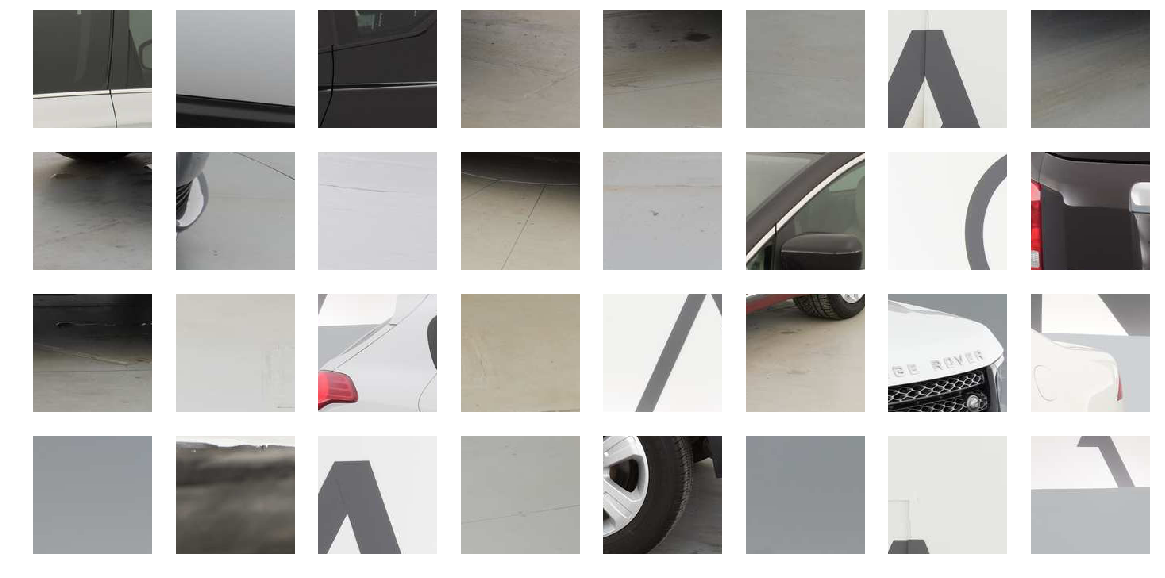

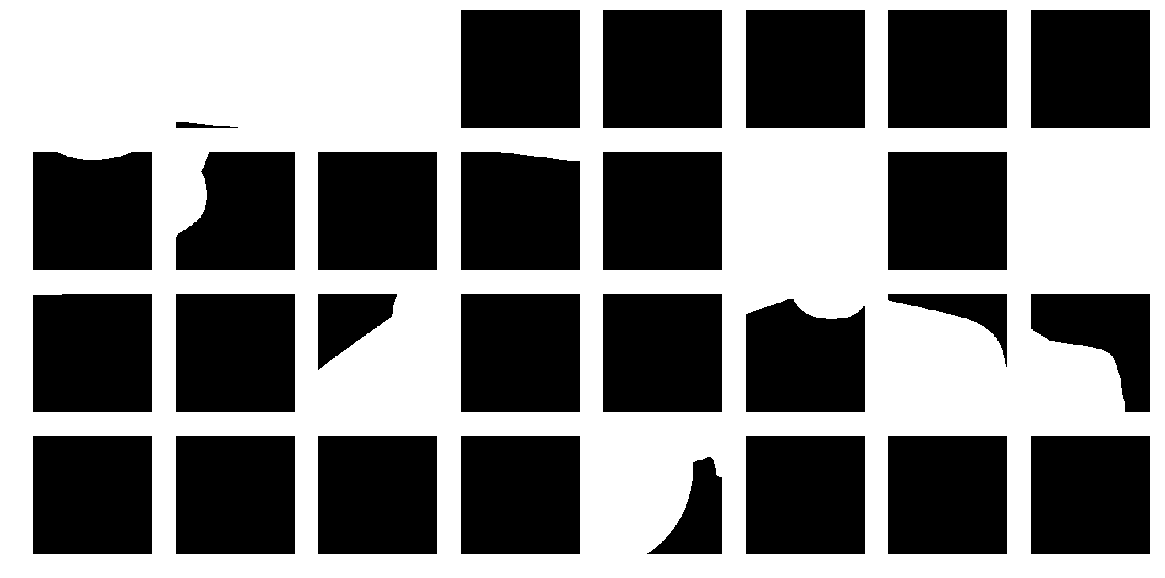

In [11]:
f, axes = plt.subplots(4, 8, figsize=(20,10));
ax = axes.flatten();
for i in range(X_train.shape[0]):
    _ = ax[i].imshow(X_train[i]);
    _ = ax[i].axis('off');
# f.suptitle('batch of 32 patches');

f, axes = plt.subplots(4, 8, figsize=(20, 10));
ax = axes.flatten();
for i in range(y_train.shape[0]):
    _ = ax[i].imshow(y_train[i].argmax(axis=2), cmap='gray', vmin=0, vmax=1);
    _ = ax[i].axis('off');
# f.suptitle('mask batch');


In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

# 把数据集切分成训练集和验证集
# 使用 StratifiedShuffleSplit 来保证训练集和验证集拥有相同比例的tumor的小图片.
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(samples, samples["is_tumor"]):
        train_samples = samples.loc[train_index]
        validation_samples = samples.loc[test_index]